In [1]:
import math
import joblib
import keras

import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras import activations, layers, initializers
from keras.models import Model
from keras.optimizers.legacy import Adam

from src.inn_layers_v2 import IntAdd, IntDense, IntConv2D, IntDropout, IntFlatten, IntMultiply, IntSilu, IntGelu
from src.inn_layers_v2 import IntZeroPadding2D, IntBatchNormalization, IntRelu, IntTanh, IntMultiply_donet
from src.deeponet_wrapper import trainer

from matplotlib import pyplot as plt
import matplotlib.patches as patches
from src import inn_layers_v2 as innv2
from src import grid_augmentation as ga
from src import clust_augmentation as ca

import scienceplots
plt.style.use('science')

import warnings
warnings.filterwarnings("ignore")


In [2]:
params = {'xtick.labelsize':12,
          'ytick.labelsize':12,
          'axes.labelsize': 16,
          'axes.titlesize': 18}
plt.rcParams.update(params)

## Standard precise dataset

In [3]:
u_in = np.load("data/poisson1Dinput.npy")
g_out = np.load("data/poisson1Doutput.npy") * 20  # the output from u_in_lo is actually lower

y_space = np.linspace(0,1,u_in.shape[1])

## Ground truth interval data

In [4]:
u_in_lo = np.load("data/poisson1Dinput_low.npy")
u_in_hi = np.load("data/poisson1Dinput_high.npy")

g_out_lo = np.load("data/poisson1Doutput_high.npy") * 20  # the output from u_in_lo is actually lower
g_out_hi = np.load("data/poisson1Doutput_low.npy") * 20

In [5]:
u_int_0 = np.stack([u_in_lo, u_in_hi], axis=-1)
g_int_0 = np.stack([g_out_lo, g_out_hi], axis=-1)

### Train-Test split

In [6]:
n_total = u_in.shape[0] #2000
n_test = 1000  # thus, n_train = 1000
n_val = 100
rand = 42
idxs = np.arange(u_in.shape[0])
idx_train, idx_test = train_test_split(idxs, test_size=n_test/n_total, 
                                        random_state=rand)
idx_val, idx_test = train_test_split(idx_test, train_size=n_val/n_test, 
                                        random_state=rand)

In [7]:
u_int = np.expand_dims(u_int_0, axis=1)
g_int = np.expand_dims(g_int_0, axis=2)

In [8]:
## Pointwise data split
u_train, u_val, u_test = u_in[idx_train,...], u_in[idx_val,...], u_in[idx_test,...]
g_train, g_val, g_test = g_out[idx_train,...], g_out[idx_val,...], g_out[idx_test,...]

## Interval data split
_,u_int_val, u_int_test = u_int[idx_train,...], u_int[idx_val,...], u_int[idx_test,...]
_,g_int_val, g_int_test = g_int[idx_train,...], g_int[idx_val,...], g_int[idx_test,...]

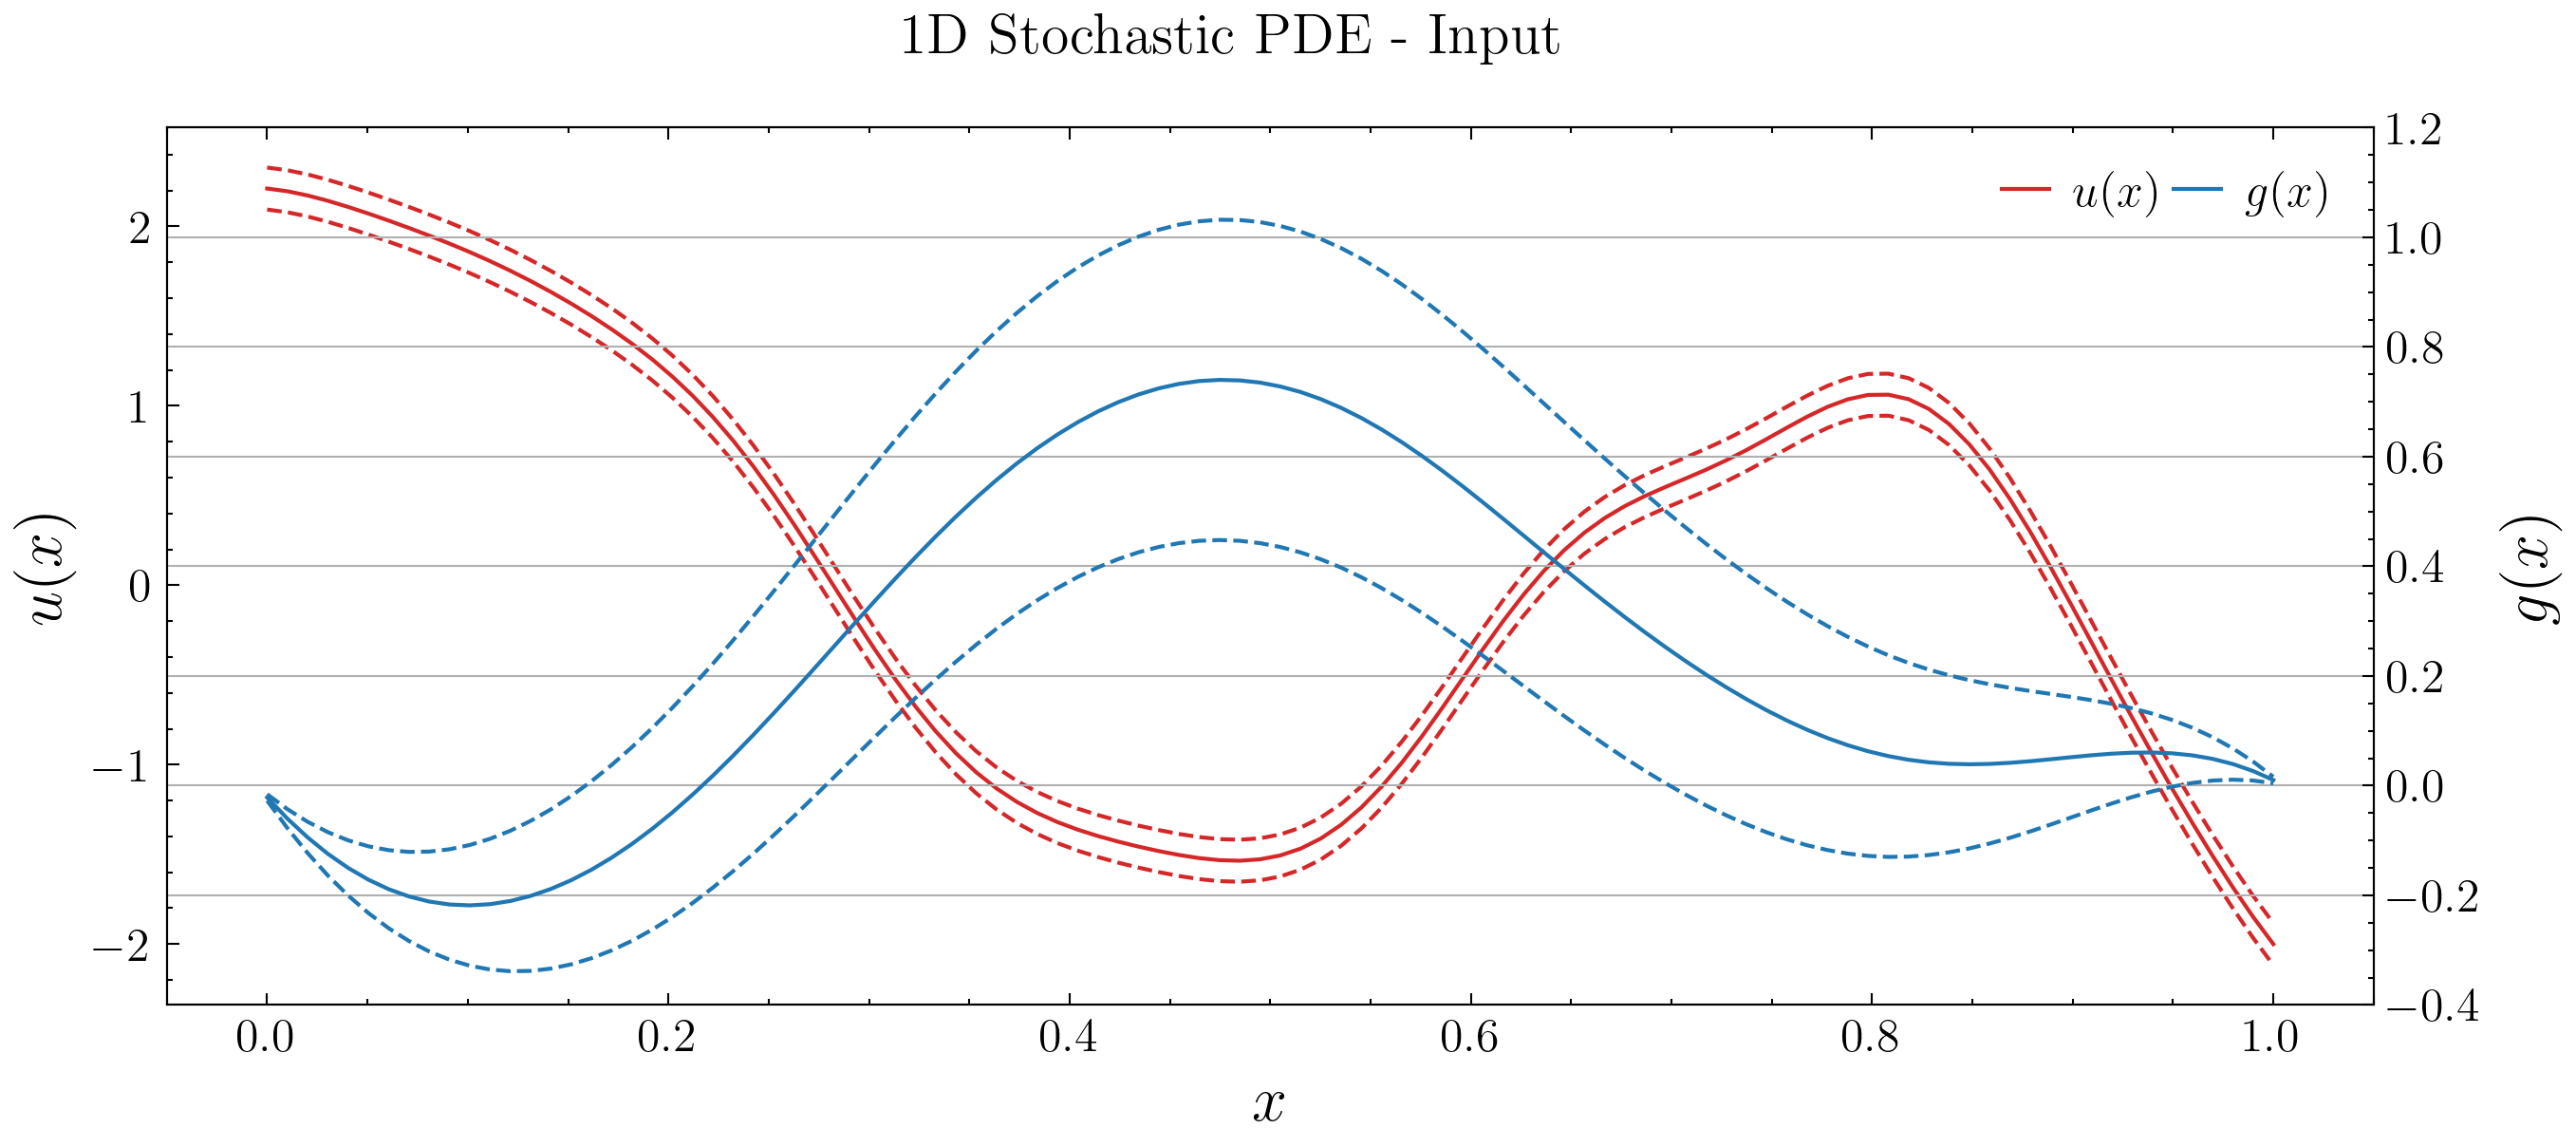

In [9]:
plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

colormap = plt.cm.jet  
colors = [colormap(i) for i in np.linspace(0, 5, 20)]

fig2, ax1 = plt.subplots(figsize = (10, 4), dpi=300)
fig2.suptitle('1D Stochastic PDE - Input')

index = 0
i = 42
color = 'tab:red'
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$u(x)$')
ax1.plot(y_space, u_int_test[i,:,:,0].T, '--', color=color)
line1 = ax1.plot(y_space, u_test[i,:].T, '-', color=color, label=r'$u(x)$')
ax1.plot(y_space, u_int_test[i,:,:,1].T, '--', color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel(r'$g(x)$')
ax2.plot(y_space, g_int_test[i,:,:,0], '--', color=color)
line2 = ax2.plot(y_space, g_test[i,:].T, '-', color=color, label=r'$g(x)$')
ax2.plot(y_space, g_int_test[i,:,:,1], '--', color=color)
ax2.set_ylim(-0.4, 1.2)

# Combine legends from both axes
lines = [line1[0], line2[0]]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='upper right', ncol=4, labelspacing=0.25, 
           columnspacing=0.25, handletextpad=0.5, handlelength=1)

plt.grid(True)
plt.margins(0)

plt.savefig("img/ideal_1dPDE.pdf", dpi=300, format="pdf")
plt.show()

### Data Augmentation

In [10]:
# grid_res = [[a]*u_train.shape[1] for a in [15]]
# u_aug_train, g_aug_train = ga.construct_interval_grid(u_train, g_train, 
#                                                      grid_res=grid_res, n_shift=2, nmax_per_res=25)

In [11]:
u_aug_train_0, g_aug_train_0, u_clust, g_clust = ca.construct_interval(u_train, g_train, n_clusters=[5,10,20,50,75,100,150,200,300])

100%|██████████| 9/9 [00:06<00:00,  1.44it/s]


In [12]:
u_aug_train = np.expand_dims(u_aug_train_0, axis=1)
g_aug_train = np.expand_dims(g_aug_train_0, axis=2)

In [13]:
u_aug_train.shape, g_aug_train.shape

((814, 1, 100, 2), (814, 100, 1, 2))

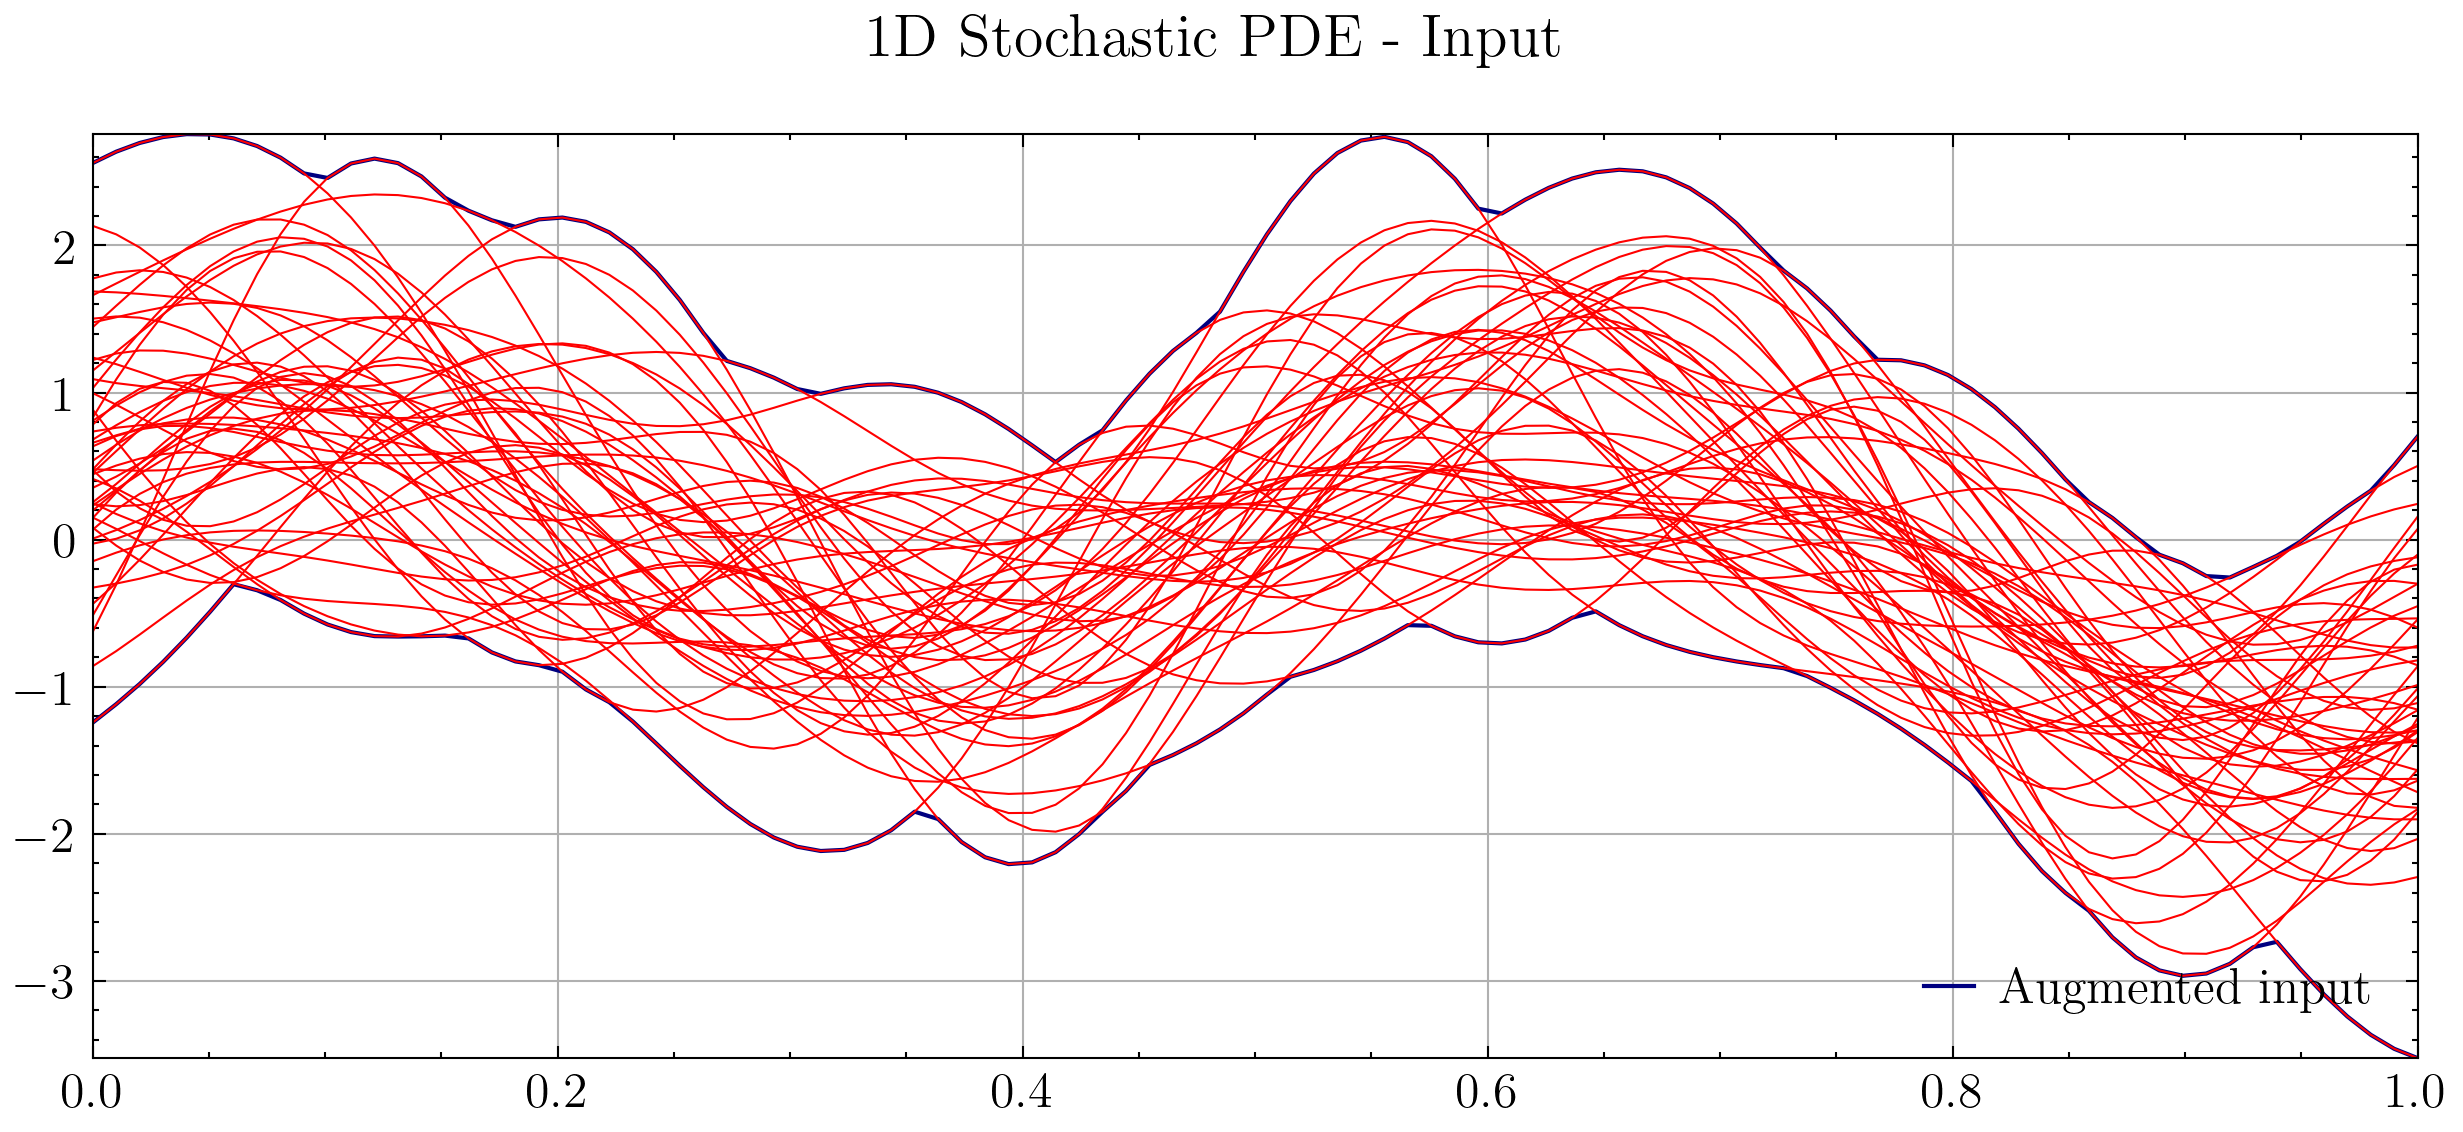

In [14]:
plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

colormap = plt.cm.jet  
colors = [colormap(i) for i in np.linspace(0, 5, 20)]

fig2 = plt.figure(figsize = (10, 4), dpi=300)
fig2.suptitle('1D Stochastic PDE - Input')

index = 0
for i in [17]:
    plt.plot(y_space, u_aug_train[i,:,:,0].T, '-', color=colors[index], label='Augmented input')
    plt.plot(y_space, u_aug_train[i,:,:,1].T, '-', color=colors[index])
    for uc in (u_clust[i]):
        plt.plot(y_space, uc.T, '-', color="red", linewidth=0.5)
    index += 1
plt.legend(ncol=4, loc=4, labelspacing=0.25, columnspacing=0.25, handletextpad=0.5, handlelength=1)
plt.grid(True)
plt.margins(0)

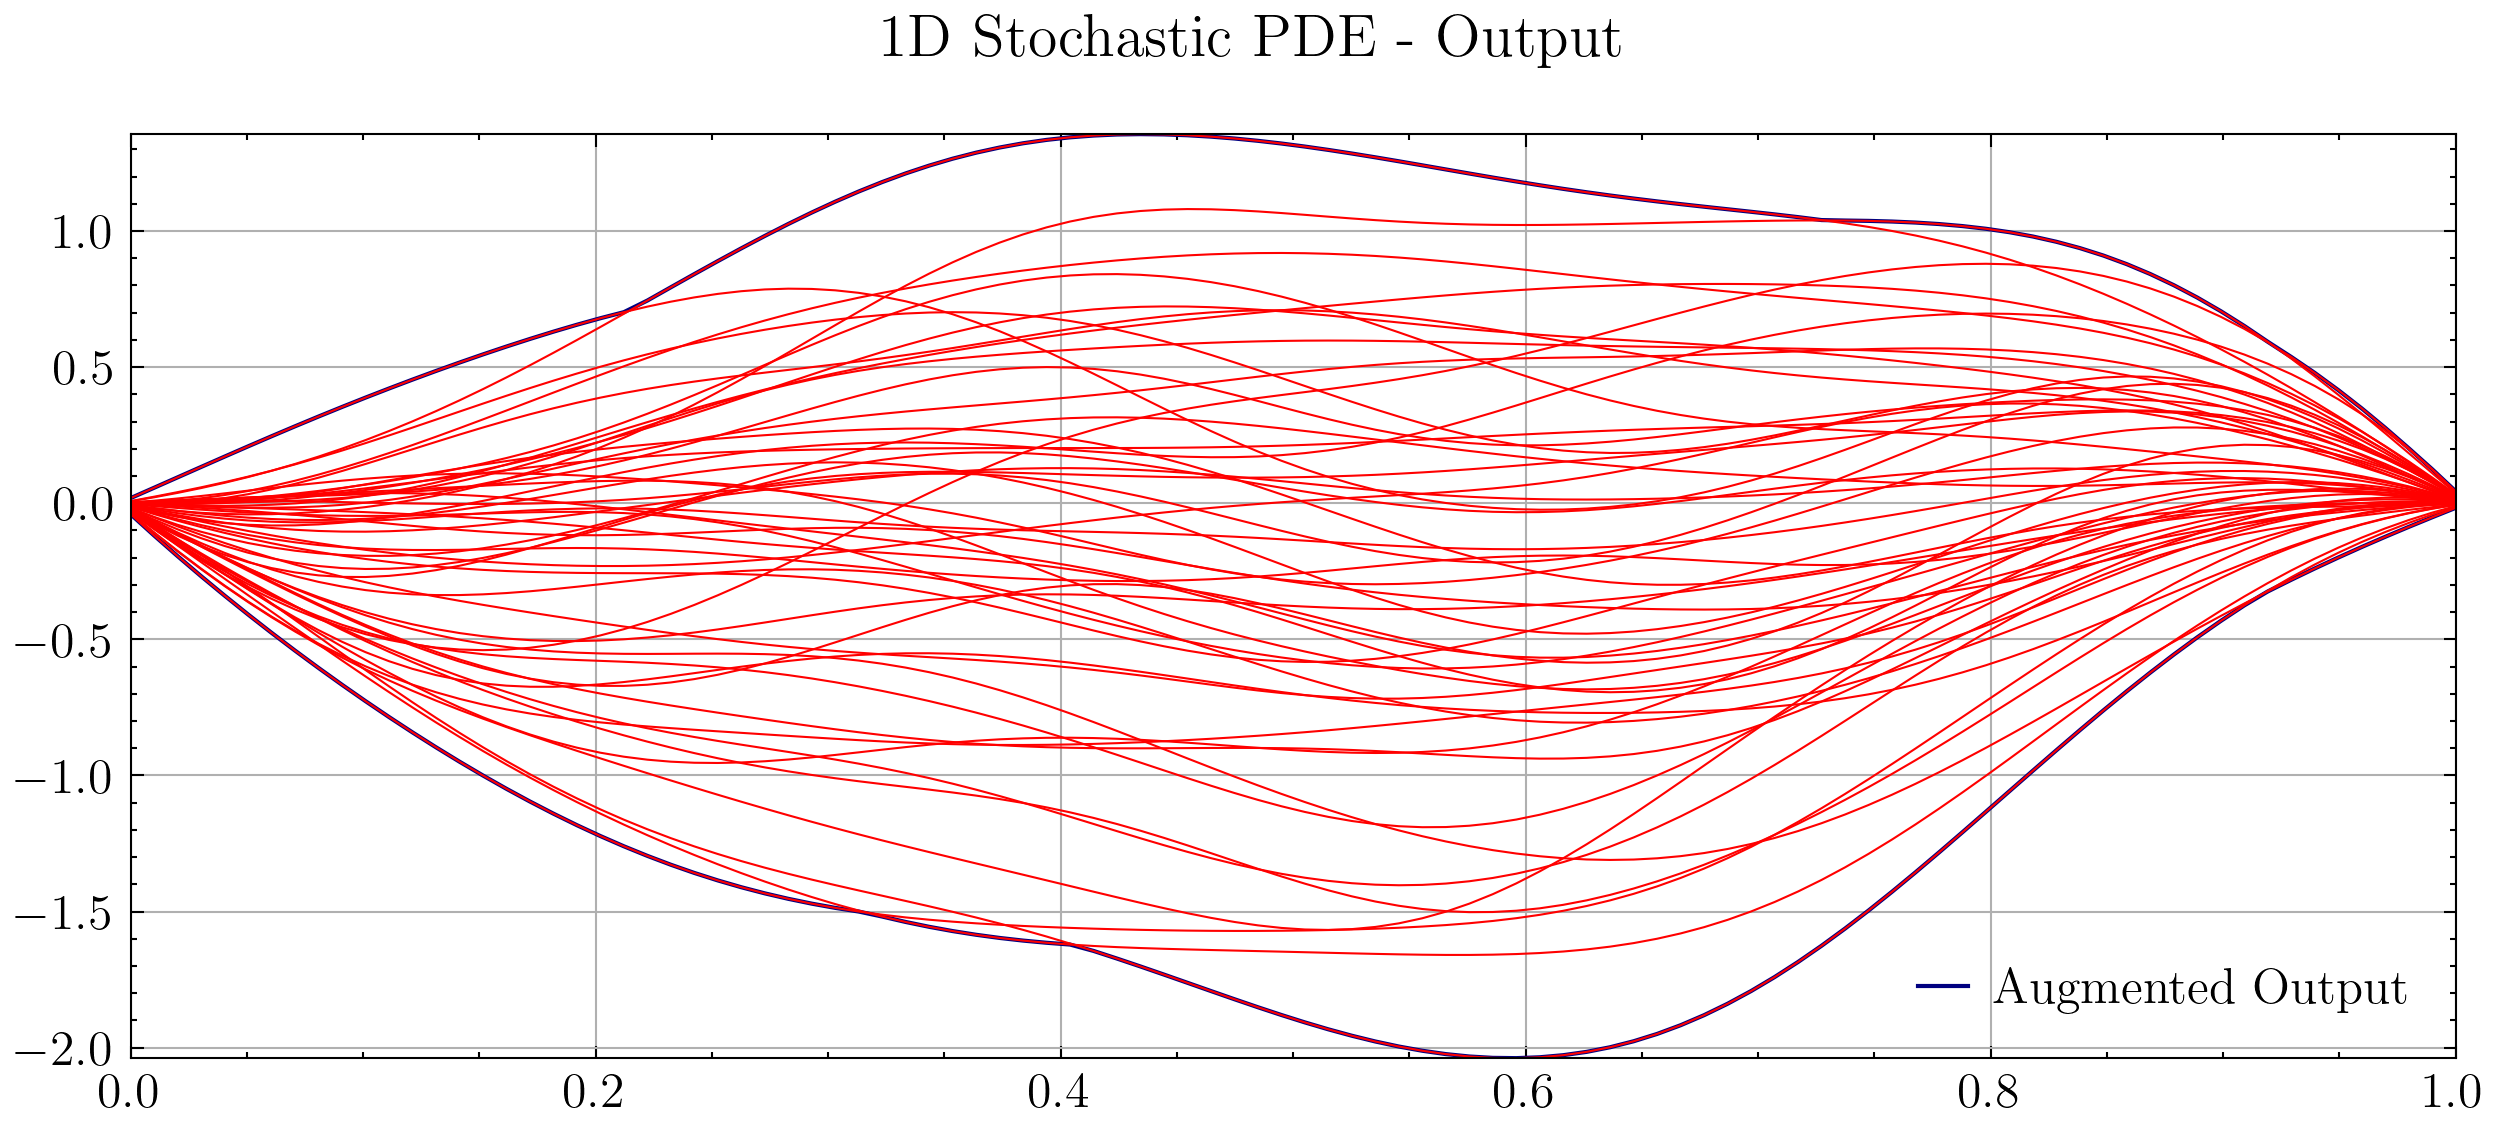

In [15]:
plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

colormap = plt.cm.jet  
colors = [colormap(i) for i in np.linspace(0, 5, 20)]

fig2 = plt.figure(figsize = (10, 4), dpi=300)
fig2.suptitle('1D Stochastic PDE - Output')

index = 0
for i in [17]:
    plt.plot(y_space, g_aug_train[i,:,:,0], '-', color=colors[index], label='Augmented Output')
    plt.plot(y_space, g_aug_train[i,:,:,1], '-', color=colors[index])
    for gc in (g_clust[i]):
        plt.plot(y_space, gc.T, '-', color="red", linewidth=0.5)
    index += 1
plt.legend(ncol=4, loc=4, labelspacing=0.25, columnspacing=0.25, handletextpad=0.5, handlelength=1)
plt.grid(True)
plt.margins(0)

## DeepONet

In [16]:
def build_mlp(inputs, output_features: int, 
              hidden_features: int, num_hidden_layers: int):
    """
    Builds an MLP regression model.
    
    Parameters:
        x: Input tensor.
        output_features (int): Number of output features.
        hidden_features (int): Number of units in each hidden layer.
        num_hidden_layers (int): Number of hidden layers.
    
    Returns:
        array: keras tensor.
    """
    x = inputs
    
    # Create hidden layers with tanh activation
    for _ in range(num_hidden_layers):
        x = layers.Dense(hidden_features, activation='silu')(x)
    
    # Output layer with linear activation for regression
    outputs = layers.Dense(output_features, activation='linear')(x)
    
    return outputs

def build_imlp(inputs, output_features: int, 
              hidden_features: int, num_hidden_layers: int):
    """
    Builds an Interval MLP regression model.
    
    Parameters:
        x: Input tensor.
        output_features (int): Number of output features.
        hidden_features (int): Number of units in each hidden layer.
        num_hidden_layers (int): Number of hidden layers.
    
    Returns:
        array: keras tensor.
    """
    x = inputs
    
    # Create hidden layers with tanh activation
    for _ in range(num_hidden_layers):
        x = IntDense(hidden_features)(x)
        x = IntSilu()(x)
    
    # Output layer with linear activation for regression
    outputs = IntDense(output_features)(x)
    
    return outputs

In [17]:
def interval_deeponet(y_in_size, u_in_size, trunk_params, branch_params, out_feat=1):
    """_summary_

    Args:
        y_in_size (tuple): spatial input size
        u_in_size (tuple): function input size
        trunk_params (dict): trunk net parameters
        branch_params (dict): branch net parameters
        out_feat (int, optional): number of output feature. Defaults to 1.

    Returns:
        keras.Model: output model
    """
    y_input = layers.Input(y_in_size)
    u_input = layers.Input(u_in_size)

    # Trunk layer
    # y_in_lo = y_input[...,0]
    # y_in_hi = y_input[...,1]
    # y_in = [y_in_lo, y_in_hi]
    trunk_out = build_mlp(y_input, trunk_params["output_features"], 
                          trunk_params["hidden_features"], trunk_params["num_hidden_layers"])
    
    # Branch layer
    u_in_lo = u_input[...,0]
    u_in_hi = u_input[...,1]
    u_in = [u_in_lo, u_in_hi]
    branch_out = build_imlp(u_in, branch_params["output_features"], 
                          branch_params["hidden_features"], branch_params["num_hidden_layers"])

    # Multiply trunk and branch
    mult_out = IntMultiply_donet()([trunk_out, branch_out])

    out = IntDense(out_feat)(mult_out)

    model = Model(inputs=[y_input, u_input], outputs=out, name="DeepONet")

    return model

In [18]:
trunk_params=dict()
trunk_params["output_features"] = 64
trunk_params["hidden_features"] = 64
trunk_params["num_hidden_layers"] = 4

branch_params=dict()
branch_params["output_features"] = 64
branch_params["hidden_features"] = 64
branch_params["num_hidden_layers"] = 4

In [19]:
onet = interval_deeponet(y_in_size=(100,1), u_in_size=(1,100,2), trunk_params=trunk_params, 
                branch_params=branch_params, out_feat=1)

2025-08-20 19:00:16.841437: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-08-20 19:00:16.841460: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-20 19:00:16.841464: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-08-20 19:00:16.841532: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-20 19:00:16.841570: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
y_space_train = np.expand_dims(np.tile(y_space,(u_aug_train.shape[0],1)), axis=-1)
y_space_val = np.expand_dims(np.tile(y_space,(u_int_val.shape[0],1)), axis=-1)
y_space_test = np.expand_dims(np.tile(y_space,(u_int_test.shape[0],1)), axis=-1)

In [21]:
y_space_train.shape, u_aug_train.shape, g_aug_train.shape

((814, 100, 1), (814, 1, 100, 2), (814, 100, 1, 2))

In [22]:
u_aug_train.shape

(814, 1, 100, 2)

In [23]:
def run_experiment(model, u_int_train, y_int_train, g_int_train,
                   u_int_val, y_int_val, g_int_val,
                   u_int_test, y_int_test, g_int_test,
                   repetitions=10, n_train = 500, epochs=500, verbose=False):
    """Run the experiment with the given model and data."""

    def sched(epoch):
        if epoch <= 200:
            lr = 1e-2
        elif epoch <= 500:
            lr = 1e-3
        else:
            lr = 1e-4
        return lr
    
    results = []

    # Choose n_train random as training data
    for seed in tqdm(range(repetitions)):
        # Compile model
        model.compile(
            optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-3)
        )

        data = dict()
        np.random.seed(seed)
        idx = np.random.choice(np.arange(u_int_train.shape[0]), size=n_train, replace=False)
        u_train_int = u_int_train[idx,...]
        y_train_int = y_int_train[idx,...]
        g_train_int = g_int_train[idx,...]

        # Train model
        model,hist = trainer(onet, y_train_int, u_train_int, g_train_int, 
                        y_val=y_int_val, u_val=u_int_val, 
                        g_val=g_int_val, loss_type="linex", 
                        epochs=epochs, batch=32, verbose=verbose, scheduler=sched)

        # Evaluate model
        pred = model.predict([y_int_test, u_int_test])
        data["u_train"] = u_train_int
        data["y_train"] = y_train_int
        data["g_train"] = g_train_int
        data["u_test"] = u_int_test
        data["y_test"] = y_int_test
        data["g_test"] = g_int_test
        data["pred"] = pred
        data["history"] = hist

        results.append(data)
        
    return results

In [24]:
results = run_experiment(onet, u_aug_train, y_space_train, g_aug_train,
                   u_int_val, y_space_val, g_int_val,
                   u_int_test, y_space_test, g_int_test,
                   repetitions=10, n_train=500, epochs=600, verbose=False)
joblib.dump(results, "output/deeponet1d_aug_inn_ntrain500.pkl")

  0%|          | 0/10 [00:00<?, ?it/s]2025-08-20 19:00:19.848265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Best model updated at epoch 102 with val_loss 1.8215
Best model updated at epoch 103 with val_loss 1.7876
Best model updated at epoch 104 with val_loss 1.7719
Best model updated at epoch 105 with val_loss 1.7497
Best model updated at epoch 106 with val_loss 1.7156
Best model updated at epoch 107 with val_loss 1.6321
Best model updated at epoch 108 with val_loss 1.5891
Best model updated at epoch 109 with val_loss 1.5452
Best model updated at epoch 110 with val_loss 1.4765
Best model updated at epoch 111 with val_loss 1.4087
Best model updated at epoch 114 with val_loss 1.3648
Best model updated at epoch 120 with val_loss 1.3048
Best model updated at epoch 127 with val_loss 1.3015
Best model updated at epoch 142 with val_loss 1.2295
Best model updated at epoch 153 with val_loss 1.2120
29/29 [==============================] - 0s 13ms/step


 10%|█         | 1/10 [14:08<2:07:15, 848.44s/it]

Best model updated at epoch 102 with val_loss 17.2817
Best model updated at epoch 103 with val_loss 17.2308
Best model updated at epoch 104 with val_loss 17.1803
29/29 [==============================] - 0s 14ms/step


 20%|██        | 2/10 [28:19<1:53:20, 850.10s/it]

Best model updated at epoch 102 with val_loss 12.4316
Best model updated at epoch 103 with val_loss 10.4104
Best model updated at epoch 104 with val_loss 9.1420
Best model updated at epoch 106 with val_loss 8.6697
Best model updated at epoch 110 with val_loss 8.5892
Best model updated at epoch 113 with val_loss 8.3451
Best model updated at epoch 133 with val_loss 8.3178
Best model updated at epoch 137 with val_loss 8.2245
Best model updated at epoch 139 with val_loss 8.1369
Best model updated at epoch 141 with val_loss 8.0360
Best model updated at epoch 142 with val_loss 8.0068
Best model updated at epoch 146 with val_loss 7.9863
Best model updated at epoch 147 with val_loss 7.8665
Best model updated at epoch 148 with val_loss 7.7827
Best model updated at epoch 150 with val_loss 7.6900
Best model updated at epoch 152 with val_loss 7.5913
Best model updated at epoch 154 with val_loss 7.3864
Best model updated at epoch 155 with val_loss 7.1724
Best model updated at epoch 156 with val_los

 30%|███       | 3/10 [42:33<1:39:21, 851.58s/it]

Best model updated at epoch 102 with val_loss 488.3467
Best model updated at epoch 103 with val_loss 481.8595
Best model updated at epoch 120 with val_loss 480.5775
Best model updated at epoch 121 with val_loss 473.7168
Best model updated at epoch 122 with val_loss 437.7458
Best model updated at epoch 123 with val_loss 383.3586
Best model updated at epoch 129 with val_loss 374.9843
Best model updated at epoch 153 with val_loss 367.1876
Best model updated at epoch 160 with val_loss 340.6262
Best model updated at epoch 161 with val_loss 326.2771
Best model updated at epoch 162 with val_loss 305.5350
Best model updated at epoch 163 with val_loss 289.3506
Best model updated at epoch 164 with val_loss 287.5488
Best model updated at epoch 165 with val_loss 249.6073
Best model updated at epoch 172 with val_loss 237.8737
Best model updated at epoch 173 with val_loss 211.7574
Best model updated at epoch 180 with val_loss 211.1379
Best model updated at epoch 182 with val_loss 155.0757
Best model

 40%|████      | 4/10 [56:28<1:24:32, 845.38s/it]

Best model updated at epoch 102 with val_loss 21738.6413
Best model updated at epoch 103 with val_loss 21704.1250
Best model updated at epoch 105 with val_loss 20978.0159
Best model updated at epoch 108 with val_loss 20946.3827
Best model updated at epoch 109 with val_loss 20709.7696
Best model updated at epoch 110 with val_loss 20689.9553
Best model updated at epoch 111 with val_loss 20435.1237
Best model updated at epoch 112 with val_loss 20191.5296
Best model updated at epoch 114 with val_loss 19936.3171
Best model updated at epoch 115 with val_loss 19652.8442
Best model updated at epoch 121 with val_loss 19370.0100
Best model updated at epoch 122 with val_loss 17943.6751
Best model updated at epoch 123 with val_loss 17433.1242
Best model updated at epoch 143 with val_loss 17429.1884
Best model updated at epoch 144 with val_loss 17329.2668
Best model updated at epoch 145 with val_loss 17254.4890
Best model updated at epoch 146 with val_loss 17140.3852
Best model updated at epoch 149

 50%|█████     | 5/10 [1:09:52<1:09:11, 830.34s/it]

Best model updated at epoch 102 with val_loss 72.1835
Best model updated at epoch 103 with val_loss 67.8097
Best model updated at epoch 104 with val_loss 66.9928
Best model updated at epoch 106 with val_loss 65.3422
Best model updated at epoch 108 with val_loss 64.2049
Best model updated at epoch 110 with val_loss 63.9857
Best model updated at epoch 112 with val_loss 61.9228
Best model updated at epoch 121 with val_loss 61.0729
Best model updated at epoch 148 with val_loss 54.8177
Best model updated at epoch 219 with val_loss 54.2522
Best model updated at epoch 223 with val_loss 53.7322
Best model updated at epoch 225 with val_loss 53.6693
Best model updated at epoch 227 with val_loss 52.9030
Best model updated at epoch 230 with val_loss 52.7319
Best model updated at epoch 332 with val_loss 52.7085
Best model updated at epoch 333 with val_loss 48.9342
Best model updated at epoch 353 with val_loss 47.0415
Best model updated at epoch 354 with val_loss 46.3839
Best model updated at epoch 

 60%|██████    | 6/10 [1:23:29<55:03, 825.81s/it]  

29/29 [==============================] - 0s 15ms/step


 70%|███████   | 7/10 [1:38:30<42:30, 850.23s/it]

29/29 [==============================] - 0s 13ms/step


 80%|████████  | 8/10 [1:54:01<29:11, 875.98s/it]

29/29 [==============================] - 0s 13ms/step


 90%|█████████ | 9/10 [2:08:32<14:34, 874.42s/it]

29/29 [==============================] - 0s 15ms/step


100%|██████████| 10/10 [2:22:28<00:00, 854.90s/it]


['output/deeponet1d_aug_inn_ntrain500.pkl']

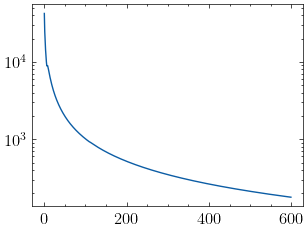

In [25]:
history = results[1]["history"]
plt.semilogy(history[0])

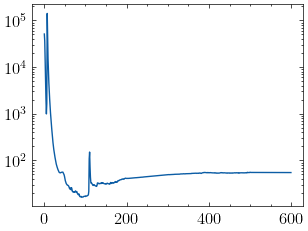

In [26]:
plt.semilogy(history[1])

## Predict

In [27]:
preds = results[1]["pred"]
g_int_test = results[1]["g_test"]

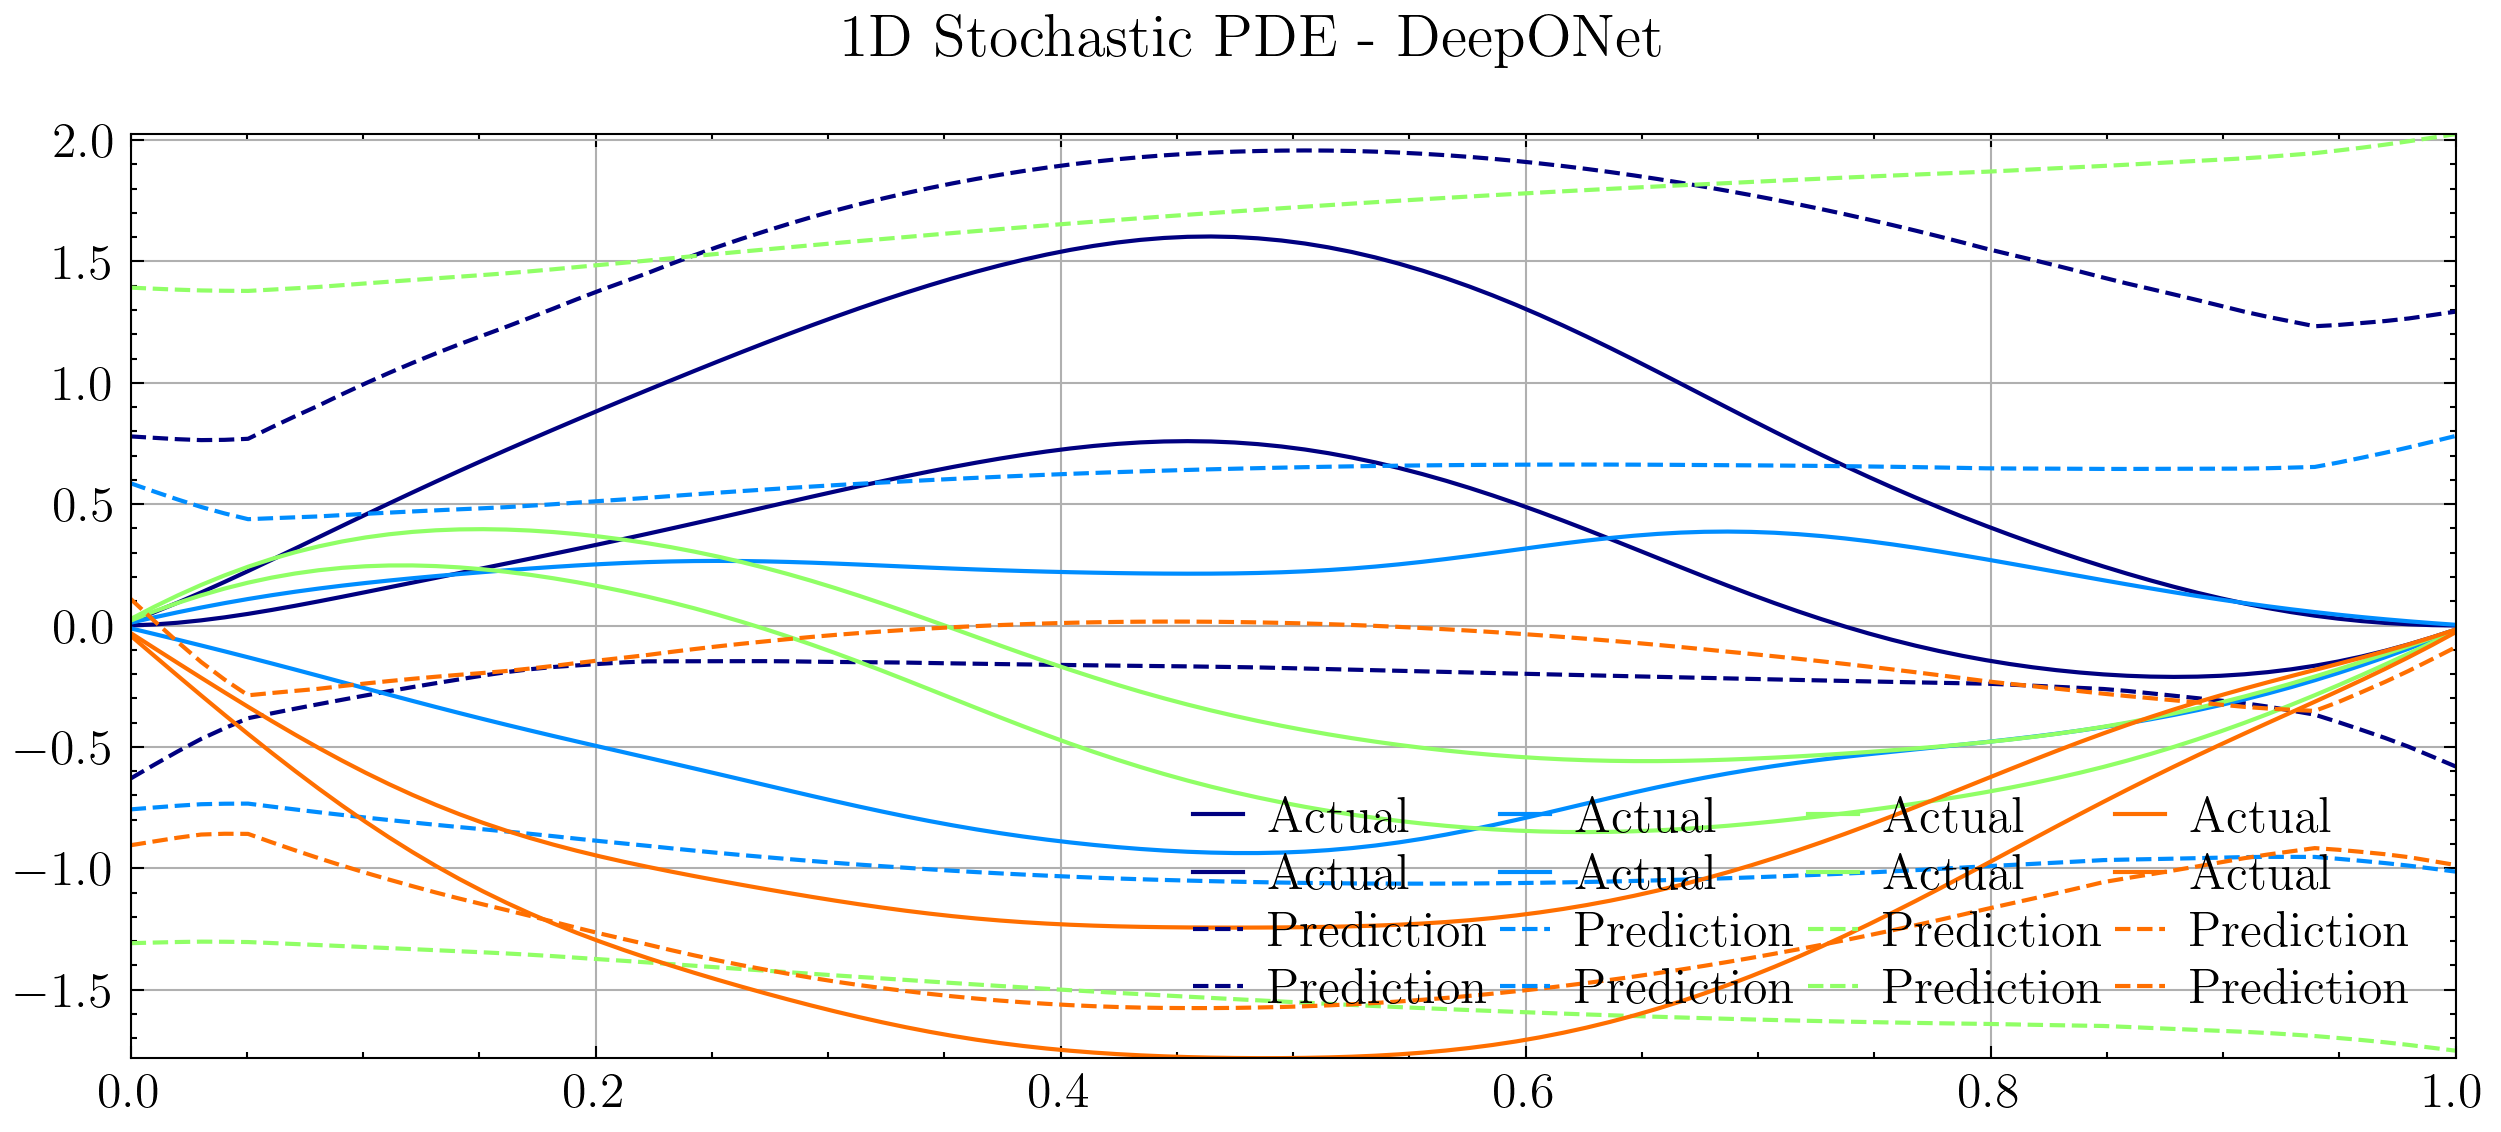

In [28]:
plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

colormap = plt.cm.jet  
colors = [colormap(i) for i in np.linspace(0, 5, 20)]

fig2 = plt.figure(figsize = (10, 4), dpi=300)
fig2.suptitle('1D Stochastic PDE - DeepONet')

index = 0
for i in [39,66,77,99]:
    plt.plot(y_space, g_int_test[i,:,:,0], color=colors[index], label='Actual')
    plt.plot(y_space, g_int_test[i,:,:,1], color=colors[index], label='Actual')
    plt.plot(y_space, preds[0][i,:,:], '--', color=colors[index], label='Prediction')
    plt.plot(y_space, preds[1][i,:,:], '--', color=colors[index], label='Prediction')
    index += 1
plt.legend(ncol=4, loc=4, labelspacing=0.25, columnspacing=0.25, handletextpad=0.5, handlelength=1)
plt.grid(True)
plt.margins(0)